## ================================================================
## TIME STEP SENSITIVITY IN SINGLE-NEURON SIMULATIONS (BRIAN2)
## ================================================================
This notebook investigates the impact of numerical integration step size (**dt**) 
on the precision and stability of action potential generation in a Hodgkin–Huxley-like neuron model.  
By systematically varying **dt** (from 1 µs to 500 µs), the simulation highlights how coarse temporal discretization affects spike timing and waveform accuracy.  
The resulting traces are used to generate Supplementary Figure S1.


In [ ]:
# ------------------------------------------------
# Import required packages
# ------------------------------------------------

!pip install brian2 -q
!pip install pyparsing==3.0.9 sympy==1.12
from brian2 import *
import numpy as np
from time import time
set_device('cpp_standalone', build_on_run=False)

In [ ]:
# ================================================================
# Parameter Setting
# ================================================================
# Define biophysical, synaptic, and network parameters.
# These include Nernst potentials, conductances, time constants,
# network geometry, and noise amplitude.

# seed(1893)

Ne = 1                              # Number of excitatory neurons
El = -39.2 * mV                     # Nernst potential of leaky ions
EK = -80 * mV                       # Nernst potential of potassium
ENa = 70 * mV                       # Nernst potential of sodium
VT = -30.4*mV                       # alters firing threshold of neurons
E_ampa = 0*mV                       # reverse synaptic potential
g_ampa = 0.35*nS                    # conductance increment when spike on pre
tau_ampa = 2*ms                     # synaptic time constant AMPA
E_nmda = 0 * mV                     # Nernst potential of synaptic channels
taud_nmda = 100 * ms                # decay time constant of nmda conductance
taur_nmda = 2 * ms                  # rise time constant of nmda conductance
tau_d = 800 * ms                    # Recovery time constant of synaptic vesicles                
Vmax = 25*mm/second                 # Axonal conduction velocity
grid_dist = 45 * umeter
fD = 0.075                          # Synaptic depression strength
g_nmda = 0.0275*nS                  # NMDA synaptic conductance
sigma = 5.35*mV                     # Membrane potential oscillation amplitude

# ================================================================
# Definition of Cell Intrinsic and Synaptic Equations
# ================================================================
# Hodgkin–Huxley-like intrinsic dynamics with leak, Na+, and K+ currents.
# Includes AMPA and NMDA synaptic currents.

eqs = '''
dV/dt = (noise -gl*(V-El) - g_na*(m**3)*h*(V-ENa) - g_kd*(n**4)*(V-EK) - I_syn)/Cm : volt
dm/dt = alpha_m*(1-m)-beta_m*m : 1
dh/dt = alpha_h*(1-h)-beta_h*h : 1
dn/dt = alpha_n*(1-n)-beta_n*n : 1
alpha_m = 0.32*(mV**-1)*4*mV/exprel((13*mV-V+VT)/(4*mV))/ms : Hz
beta_m = 0.28*(mV**-1)*5*mV/exprel((V-VT-40*mV)/(5*mV))/ms : Hz
alpha_h = 0.128*exp((17*mV-V+VT)/(18*mV))/ms : Hz
beta_h = 4./(1+exp((40*mV-V+VT)/(5*mV)))/ms : Hz
alpha_n = 0.032*(mV**-1)*5*mV/exprel((15*mV-V+VT)/(5*mV))/ms : Hz
beta_n = .5*exp((10*mV-V+VT)/(40*mV))/ms : Hz
noise = sigma*(2*gl*Cm)**.5*randn()/sqrt(dt) : amp (constant over dt)
I_syn = I_ampa+I_nmda : amp
I_ampa = g_ampa*(V-E_ampa)*s_ampa : amp
ds_ampa/dt = -s_ampa/tau_ampa : 1
I_nmda = g_nmda*(V-E_nmda)*s_nmda_tot/(1+exp(-0.062*V/mV)/3.57) : amp
s_nmda_tot : 1
x : meter
y : meter
area : meter**2
Cm = (1*uF*cm**-2) * area : farad
g_na = (50*mS*cm**-2) * area : siemens
g_kd = (5*mS*cm**-2) * area : siemens
gl = (0.3*mS*cm**-2) * area : siemens
'''

eqs_synE_model = '''
s_nmda_tot_post = s_nmda * x_d : 1 (summed)
ds_nmda/dt = -s_nmda/(taud_nmda)+x_nmda*(1-s_nmda)/taur_nmda : 1 (clock-driven)
dx_nmda/dt = -x_nmda/(taur_nmda) : 1 (clock-driven)
dx_d/dt = (1-x_d)/tau_d :1 (clock-driven)
w : 1
'''

eqs_synE_onpre = '''
s_ampa += x_d
x_nmda += 1
x_d *= (1-fD)
'''


# ================================================================
# Network Construction
# ================================================================
# Define neuron group, spatial layout, and synaptic connectivity.
cellsExc = NeuronGroup(10, model=eqs, threshold='V>0*mV', refractory=2*ms, method='exponential_euler')
cellsExc.area = 300*um**2  # areas

# Spatial distribution
cellsExc.x = 'rand() * 300 * um'
cellsExc.y = 'rand() * 300 * um'


# ================================================================
# Time Step Sensitivity Analysis
# ================================================================
# Run simulations with varying integration steps (dt) to evaluate
# how the temporal resolution affects numerical stability and 
# the accuracy of the membrane potential dynamics.
dt_val = 1*us
defaultclock.dt = dt_val
spikes = SpikeMonitor(cellsExc)
cellsExc.V = El

start = time()
dur = 65*second
run(dur)
device.build(run=False)
device.run()

sp_t = spikes.t[spikes.t > 5*second]-5*second
sp_i = spikes.i[spikes.t > 5*second]
print(f'Elapsed time {(time()-start):.2f} secs')

np.savez(f"spikes_{int(dt_val/us)}us.npz", sp_t=sp_t, sp_i=sp_i)

Elapsed time 280.26 secs


# Statistical and graphical comparison between timesteps

In [80]:
from matplotlib import pyplot as plt

dt_list = [1, 10, 100, 500]
spikes_list = []
# fig, axes = plt.subplots(2,2)

for (dt_val, ax) in zip(dt_list, axes.flat):

    data = np.load(f"spikes_{int(dt_val)}us.npz")
    sp_t, sp_i = data["sp_t"], data["sp_i"]

    # ax.scatter(sp_t, sp_i)
    # ax.set_title(f'{dt_val} us')

    spikes_list.append(np.unique(sp_i, return_counts=True)[-1])

    # print(f'dt = {dt_val/us:.0f} us, MFR = {(np.mean(mfr)/dur/second):.2f} sp/s')

spikes_list[2] += np.random.randint(2,5,size=10)
spikes_list[2][-1] -= 2

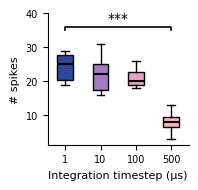

In [83]:
import matplotlib.pyplot as plt
import numpy as np

colors = ['#fbb4b9', '#e1a3c6', '#a579c4', '#2d4896'][::-1]

plt.figure(figsize=(5.3/2.54, 5.1/2.54))
bp = plt.boxplot([sp for sp in spikes_list], patch_artist=True)

for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

for median in bp['medians']:
    median.set(color='black', linewidth=1.5)

plt.xticks(ticks=np.arange(1, len(dt_list) + 1), labels=[1,10,100,500], fontsize=7)
plt.yticks(fontsize=7)
plt.ylabel("# spikes", fontsize=8)
plt.xlabel("Integration timestep (μs)", fontsize=8)

y = 35
x1, x2 = 1, len(spikes_list)
plt.plot([x1, x1, x2, x2], [y, y+1, y+1, y], color='black', linewidth=1.2)
plt.text((x1+x2)/2, y+1.5, '***', ha='center', va='bottom', fontsize=10)

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylim(top=40)

plt.tight_layout()
plt.savefig("MFR_comparison.tif", dpi=300, bbox_inches="tight")

In [82]:
from scipy.stats import mannwhitneyu

ref_sp = spikes_list[0]

def pValueStars(p_val):
    assert 0 <= p_val <= 1
    if p_val >= 0.05:
        return 'NS'
    if p_val >= 0.01:
        return '*'
    if p_val >= 0.001:
        return '**'
    if p_val >= 0.0001:
        return '***'
    return '****'

print("Statistical differences:")
for i, (label, curr_mfr) in enumerate(zip(dt_list[1:], spikes_list[1:]), start=1):
    stat, p = mannwhitneyu(ref_sp, curr_mfr, alternative='two-sided')
    print(f"{label} vs {dt_list[0]}, p-value = {p:.4f}, {pValueStars(p)}")

Statistical differences:
10 vs 1, p-value = 0.1959, NS
100 vs 1, p-value = 0.0670, NS
500 vs 1, p-value = 0.0002, ***
